# I) Summary

**DISCLAIMER**: 

- We will use the weights/biases of a pretained caffe model from this [website](http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/). 

- Local Response Normalization will not be implemented since Keras doesn't support it anymore. 

[AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) architecture:

- **5 Convolutional layers**.
- **3 Fully connected layers**.
- **3 Overlapping Max pooling layers**.
- **ReLU** as activation function for hidden layer.

    - Avoid vanishing gradients for positive values.
    - More computationally efficient to compute than sigmoid and tanh.
    - Better convergence performance than sigmoid and tanh.

- **Softmax** as activation function for output layer.
- **60,000,000 trainable parameters**.
- **Cross-entropy** as cost function
- **Mini-batch gradient descent with Momentum optimizer**.
    - Batch size : 128.
    - Momentum = 0.9.
    - Weight decay = 0.0005.
    - Learning rate: 0.01. Equal learning rate for all layers and diving by 10 when validation error stopped  improving.
- **Local Response Normalization** 
    - it helps with generalization.

--- 

AlexNet details:

- Trained with **ILSVRC-2012** dataset (1.2 million training images, 50,000 validation images, and 150,000 testing images.).
- Trained on **90 epochs**.
- **Weight initialization**: zero-mean Gaussian distribution and a standard deviation of 0.01.
- **Bias initialization**: 1 for 2nd/4th/5th conv layers and all fully-connected layers and 0 for remaining layers.

--- 

AlexNet inputs:

- **RGB image of size 256 x 256**. If not, training/test set images need to be resized.
   - Example: image_size = 1024 x 500 => Smaller dimension is resized to 256 and resulting image is cropped  to obtain a 256 x 256 image.
 
- the RGB image of size 256 x 256 will then be **cropped into 227 x 227** (cf Data Augmentation part). The paper mistakenly says 224 x 224.

--- 

AlexNet is proned to overfit, thus to prevent that:

- **Dropout**.
    - 50% dropout rate.
- **Data Augmentation**.
    - **Translations and horizontal reflections (mirroring)**: Extract random 227 x 227 crops from 256 x 256 images.
        - Translation on 1 image: (256−227)∗(256−227) = 841 possible images.
        - Mirroring : x2 the training set size.
        - New training set size = 1.2 millions * 2 * 841 = 1.2 millions * 1682 images.
    - **Altering the intensities of RGB channels**: performing PCA on the set of RGB pixel values throughout the ImageNet training set. Doing this approximately captures an important property of natural images: object identity is invariant to changes in the intensity and color of the illumination.

**Remark**:

- According to the paper, they only trained on 1.2 millions training data without using data augmentation. The reason is the following:
    - Suppose they could get 0.001s per forward/backward pass. It will take (0.001 * 1,200,000 * 1682 * 90) / (60 * 60 * 24 * 365) ~= **5.7 years** to train the model.


![legend](../../img/legend.png)

![alexnet-model](../../img/alexnet-model.png)

Noteworthy are the splitting of some of the convolutional layer (layer two, four and five). It has been used to split up the computation between two GPUs (I guess because GPUs weren’t so strong at that time). Even if that might not be necessary today, we have to define the same splitting to reproduce AlexNet results, although we only use one GPU.

# II) Implementation

In [9]:
from utils import *
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

## a) Architecture build

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, Lambda, Cropping2D

In [11]:
def grouped_conv(input_val, name, half, filters, kernel_size, strides=1, padding='valid'):
    """
        Performs a grouped convolution.
        
        Parameters:
        -input_val: previous layer.
        -name: name of the convolution.
        -half: Number of channels for each convolution.
        -filters: Number of filters for each convolution.
        -kernel_size: Kernel size used for each convolution.
        -strides: stride. Default value is 1.
        -padding: 'valid'(default) or 'same'.
        
        Returns:
        -conv: concatenation of the 2 previous convolution layer.
        
    """
    input_val_1 = Lambda(lambda x: x[:, :, :, :half])(input_val)
    input_val_2 = Lambda(lambda x: x[:, :, :, half:])(input_val)
    
    conv_1 = Conv2D(filters=filters, 
                   kernel_size=kernel_size,
                   padding=padding,
                   activation='relu',
                   name=name + '_1')(input_val_1)
    
    conv_2 = Conv2D(filters=filters, 
                   kernel_size=kernel_size,
                   padding=padding,
                   activation='relu',
                   name=name + '_2')(input_val_2)
    
    conv = Concatenate(name=name)([conv_1, conv_2])
    
    return conv

In [12]:
def AlexNet():
    x = Input((227, 227, 3))
    
    conv1 = Conv2D(filters=96, 
                   kernel_size=(11, 11),
                   strides=4,
                   activation='relu',
                   name='conv1')(x)
    
    pool1 = MaxPooling2D(pool_size=3,
                         strides=2)(conv1)
     
    conv2 = grouped_conv(input_val=pool1,
                         name='conv2', 
                         half=48,
                         filters=128,
                         kernel_size=5,
                         padding='same')
    
    pool2 = MaxPooling2D(pool_size=3,
                         strides=2)(conv2)
    
    conv3 = Conv2D(filters=384, 
                   kernel_size=(3, 3),
                   padding='same',
                   activation='relu',
                   name='conv3')(pool2)
    
    conv4 = grouped_conv(input_val=conv3,
                         name='conv4', 
                         half=192,
                         filters=192,
                         kernel_size=3,
                         padding='same')
    
    conv5 = grouped_conv(input_val=conv4,
                         name='conv5', 
                         half=192,
                         filters=128,
                         kernel_size=3,
                         padding='same')
    
    pool5 = MaxPooling2D(pool_size=3,
                         strides=2)(conv5)
    
    flatten = Flatten()(pool5)
    
    fc6 = Dense(4096, activation='relu', name='fc6')(flatten)
    
    fc7 = Dense(4096, activation='relu', name='fc7')(fc6)
    
    fc8 = Dense(1000, activation='softmax', name='fc8')(fc7)
    
    model = Model(inputs=x, outputs=fc8)
    
    return model

In [13]:
model = AlexNet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 55, 55, 96)   34944       input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 27, 27, 96)   0           conv1[0][0]                      
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 27, 27, 48)   0           max_pooling2d_3[0][0]            
____________________________________________________________________________________________

## b) Loading pretrained model

The bundled model is the iteration 360,000 snapshot. The best validation performance during training was iteration 358,000 with validation accuracy 57.258% and loss 1.83948. This model obtains a top-1 accuracy 57.1% and a top-5 accuracy 80.2% on the validation set, using just the center crop. (Using the average of 10 crops, (4 + 1 center) * 2 mirror, should obtain a bit higher accuracy.)

In [14]:
# Download pretrained model.
urllib.request.urlretrieve('http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy', 'bvlc_alexnet.npy')

('bvlc_alexnet.npy', <http.client.HTTPMessage at 0x7f18397fa978>)

In [15]:
# Load pretrained weights/biases into 'dic' dictionnary.
dic = np.load('bvlc_alexnet.npy', encoding = 'bytes', allow_pickle=True).item()
# Load weights/biases to model.
model = load_model(model, dic)
# Check if properly loaded.
check_loaded(model, dic)
# Remove 'bvlc_alexnet.npy'.
os.remove('bvlc_alexnet.npy')

Loading complete.
fc6: weights -> Loaded | biases -> Loaded
fc7: weights -> Loaded | biases -> Loaded
fc8: weights -> Loaded | biases -> Loaded
conv3: weights -> Loaded | biases -> Loaded
conv2: weights -> Loaded | biases -> Loaded
conv1: weights -> Loaded | biases -> Loaded
conv5: weights -> Loaded | biases -> Loaded
conv4: weights -> Loaded | biases -> Loaded


## c) Testing 

In [16]:
import cv2
from caffe_classes import class_names

In [17]:
current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'img/')
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]

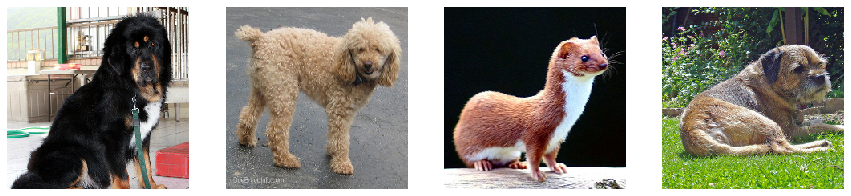

In [18]:
#load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))
    
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(1,4,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

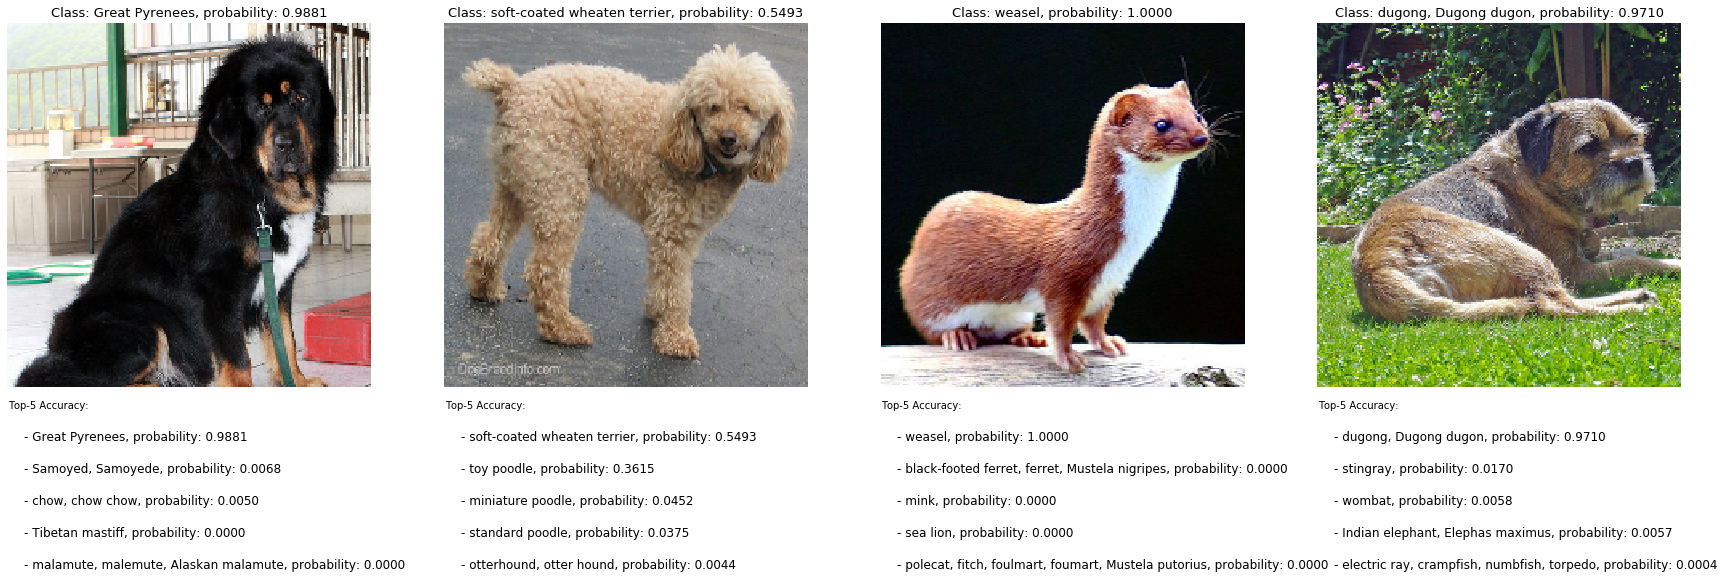

In [19]:
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

fig2 = plt.figure(figsize=(30,10))

for i, image in enumerate(imgs):
    img = cv2.resize(image.astype(np.float32), (227,227))
    img -= imagenet_mean
    img = img.reshape((1,227,227,3))
    
    probs = model.predict(img)                 
    class_name = class_names[np.argmax(probs)]
    
    fig2.add_subplot(1,4,i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)], fontsize=13)
    plt.axis('off')
    
    plt.text(0, 240, 'Top-5 Accuracy:')
    x, y = 10, 260
    for idx in np.argsort(probs)[0][-5::][::-1]:
        plt.text(x, y, s ='- {}, probability: {:.4f}'.format(class_names[idx], probs[0, idx]), fontsize=12)
        y += 20
    print()